# Data Mining Course Spark Exercise
## Sharif University of Technology

In this notebook we are going to analyze farsi wikipedia. 
Outline of the exercise:
* Dataset preparation (5 Points)
* Preprocessing (35 Points) 
* Exploration (20 Points) 
* TF-IDF + Search (40 Points)

You should replace the `TODO` parts with your implementation. Remeber that each `TODO` may take multiple lines and you shouldn't limit your self to one-line codes.

## Prerequisites
You should be faimilar with [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). In this notebook you should use the following formula for tf-idf:
$$f_{t,d}/len(d) \times log(1 + \frac{N}{n_t})$$

## Warning: RDD api only
You **can not** use Dataframe, Dataset, mllib, ml, ... apis of spark in this exercise. You should only use the [RDD api](http://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.RDD).

# Section 0: Please enter your name below
# Name: امین کشیری
# Student Number: 97101026

# Section 1: Dataset preparation (5 Points)

This section of notebook contains only shell commands. You don't need to completely understand each command or change anything.

Please run all the paragraphs sequentially.

In [ ]:
! sudo apt-get -y install wget git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git is already the newest version (1:2.17.1-1ubuntu0.9).
wget is already the newest version (1.19.4-1ubuntu2.2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


## Download the dump

In [ ]:
! wget --no-check-certificate -P . https://dumps.wikimedia.your.org/fawiki/latest/fawiki-latest-pages-articles-multistream.xml.bz2

--2021-11-06 19:24:01--  https://dumps.wikimedia.your.org/fawiki/latest/fawiki-latest-pages-articles-multistream.xml.bz2
Resolving dumps.wikimedia.your.org (dumps.wikimedia.your.org)... 204.9.55.82, 2001:4978:1:420::cc09:3752
Connecting to dumps.wikimedia.your.org (dumps.wikimedia.your.org)|204.9.55.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002962062 (956M) [application/x-bzip]
Saving to: ‘./fawiki-latest-pages-articles-multistream.xml.bz2’

fawiki-latest-pages 100%[===================>] 956.50M   154MB/s    in 5.9s    

2021-11-06 19:24:07 (161 MB/s) - ‘./fawiki-latest-pages-articles-multistream.xml.bz2’ saved [1002962062/1002962062]



## Extract the dump (this may take a few minutes)

In [ ]:
! bzip2 -d fawiki-latest-pages-articles-multistream.xml.bz2

## Clone git project for converting wikipedia xml dump to json

In [ ]:
! pip install wikiextractor

     |████████████████████████████████| 46 kB 3.0 MB/s 


## Run the script to convert xml to json (this might take around 30 minutes)

In [ ]:
! python -m wikiextractor.WikiExtractor --json fawiki-latest-pages-articles-multistream.xml

INFO: Preprocessing 'fawiki-latest-pages-articles-multistream.xml' to collect template definitions: this may take some time.
INFO: Preprocessed 100000 pages
INFO: Preprocessed 200000 pages
INFO: Preprocessed 300000 pages
INFO: Preprocessed 400000 pages
INFO: Preprocessed 500000 pages
INFO: Preprocessed 600000 pages
INFO: Preprocessed 700000 pages
INFO: Preprocessed 800000 pages
INFO: Preprocessed 900000 pages
INFO: Preprocessed 1000000 pages
INFO: Preprocessed 1100000 pages
INFO: Preprocessed 1200000 pages
INFO: Preprocessed 1300000 pages
INFO: Preprocessed 1400000 pages
INFO: Preprocessed 1500000 pages
INFO: Preprocessed 1600000 pages
INFO: Preprocessed 1700000 pages
INFO: Preprocessed 1800000 pages
INFO: Preprocessed 1900000 pages
INFO: Preprocessed 2000000 pages
INFO: Preprocessed 2100000 pages
INFO: Preprocessed 2200000 pages
INFO: Preprocessed 2300000 pages
INFO: Preprocessed 2400000 pages
INFO: Preprocessed 2500000 pages
INFO: Preprocessed 2600000 pages
INFO: Preprocessed 2700000

## Ensure output files exist

In [ ]:
! ls text/*/*

ls: cannot access 'text/*/*': No such file or directory


## Save extracted files

Below code can be used to save extracted file to google drive. This makes future loads much faster

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# cp -r text drive/MyDrive/Colab\ Notebooks/MDA/HW2

Mounted at /content/drive


## Copy from drive instead of extracting again

This code can be used to copy extracted file from drive to colab dir. But, you can read directly from drive instead of coping file from drive. Only use this step if you want to unmount google drive.

In [ ]:
# !mkdir text
# !cp -r drive/MyDrive/Colab\ Notebooks/MDA/HW2/text/* text
# !du -hs * #check if 3.0G data is there

## Install Pypark & Initialization
Uncomment this section if you use google colab or local pc

In [3]:
! pip install pyspark

     |████████████████████████████████| 281.3 MB 37 kB/s 
     |████████████████████████████████| 198 kB 15.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=5994776358b67576781e2a1fdeac903d29faabf183d09b3635537ae8b89d33a4
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [1]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .config('spark.ui.port', '4050') \
    .appName("MDA_2021") \
    .master("local[*]") \
    .getOrCreate()

sc=spark.sparkContext

#### Run Spark UI for colab

In this section, you can run Spark UI for colab. This helps analysing spark.

In [ ]:
!wget -qnc https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -n -q ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')
!sleep 5
!curl -s http://localhost:4040/api/tunnels 

{"tunnels":[{"name":"command_line","uri":"/api/tunnels/command_line","public_url":"https://40ff-104-196-111-128.ngrok.io","proto":"https","config":{"addr":"http://localhost:4050","inspect":true},"metrics":{"conns":{"count":0,"gauge":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0},"http":{"count":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0}}},{"name":"command_line (http)","uri":"/api/tunnels/command_line%20%28http%29","public_url":"http://40ff-104-196-111-128.ngrok.io","proto":"http","config":{"addr":"http://localhost:4050","inspect":true},"metrics":{"conns":{"count":0,"gauge":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0},"http":{"count":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0}}}],"uri":"/api/tunnels"}


## Reading the data

LOAD should be set to true only if you want to read from another dir. If you are extracting the file in the default dir, set LOAD to false to use default dir.

In [2]:
LOAD = True
path = 'text/*/*'
if LOAD:
  from google.colab import drive
  drive.mount('/content/drive')
  path = 'drive/MyDrive/Colab\ Notebooks/MDA/HW2/text/*/*'
articles_rdd_orig = sc.textFile(path) # Now you have a RDD with wikipedia posts
articles_rdd_orig.take(1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['{"id": "2", "revid": "23528", "url": "https://fa.wikipedia.org/wiki?curid=2", "title": "\\u0635\\u0641\\u062d\\u0647\\u0654 \\u0627\\u0635\\u0644\\u06cc", "text": "&lt;templatestyles src=\\"\\u0635\\u0641\\u062d\\u0647 \\u0627\\u0635\\u0644\\u06cc/styles.css\\"/&gt;\\n \\n \\n \\n \\n \\n \\n \\n \\n \\n \\n \\n \\n\\u0627\\u0645\\u0631\\u0648\\u0632: \\u060c \\u0645\\u06cc\\u0644\\u0627\\u062f\\u06cc \\u0628\\u0631\\u0627\\u0628\\u0631 \\u0647\\u062c\\u0631\\u06cc \\u062e\\u0648\\u0631\\u0634\\u06cc\\u062f\\u06cc \\u0648 (UTC)\\n \\n \\n \\n \\n \' \\u2013 \'\\n \\n \\n \\n \\n \\n \\n __NOEDITSECTION__"}']

# Section 2: Preprocessing (35 Points)

In this section we will remove useless part (for example /n and /u200c) also find and remove stop words and remove the words with a low count in the corpus

### Step by Step

If you want to run sample only, set SAMPLE to True and also set SAMPLE_SIZE. Else, all data will be used

In [ ]:
SAMPLE = True
SAMPLE_SIZE = 0.01

In [ ]:
if SAMPLE:
  articles_rdd = articles_rdd_orig.sample(True, SAMPLE_SIZE)
  articles_rdd = articles_rdd.coalesce(10)
  articles_rdd.cache()
else:
  articles_rdd = articles_rdd_orig

articles_rdd.take(1)

['{"id": "1408", "revid": "762412", "url": "https://fa.wikipedia.org/wiki?curid=1408", "title": "\\u062a\\u0648\\u0644\\u06cc \\u062e\\u0627\\u0646", "text": "\\u062a\\u0648\\u0644\\u06cc \\u062e\\u0627\\u0646 \\u06cc\\u0627 \\u062a\\u0648\\u0644\\u0648\\u06cc \\u062e\\u0627\\u0646\\u060c \\u067e\\u0633\\u0631 \\u0686\\u0647\\u0627\\u0631\\u0645 \\u0686\\u0646\\u06af\\u06cc\\u0632 \\u062e\\u0627\\u0646 \\u06a9\\u0647 \\u0627\\u0632 \\u0628\\u0631\\u0627\\u062f\\u0631\\u0627\\u0646 \\u062e\\u0648\\u062f \\u062c\\u0648\\u062c\\u06cc \\u0648 \\u062c\\u063a\\u062a\\u0627\\u06cc \\u0648 \\u0627\\u0648\\u06af\\u062a\\u0627\\u06cc \\u06a9\\u0648\\u0686\\u06a9\\u200c\\u062a\\u0631 \\u0628\\u0648\\u062f \\u0648 \\u062f\\u0631 \\u062f\\u0644\\u0627\\u0648\\u0631\\u06cc \\u0648 \\u0642\\u0644\\u0639\\u0647 \\u06af\\u0634\\u0627\\u06cc\\u06cc \\u0648 \\u0633\\u067e\\u0627\\u0647\\u06cc\\u06af\\u0631\\u06cc \\u0645\\u0627\\u0646\\u0646\\u062f \\u0646\\u062f\\u0627\\u0634\\u062a. \\u0647\\u06cc\\u06

parsing the json string


In [ ]:
import json
articles_rdd_json = articles_rdd.map(lambda x: json.loads(x))
articles_rdd_json.take(1)

[{'id': '1408',
  'revid': '762412',
  'text': 'تولی خان یا تولوی خان، پسر چهارم چنگیز خان که از برادران خود جوجی و جغتای و اوگتای کوچک\u200cتر بود و در دلاوری و قلعه گشایی و سپاهیگری مانند نداشت. هیچ\u200cیک از پسران و برادران چنگیز مانند وی لشکرکشی و فتوحات نکرده\u200cاند. چنگیز در اوایل میل داشت که او را به جانشینی تعیین کند اما بعد نظرش تغییر کرد و گفت که منصب لشکرکشی و ضبط یورت و حفظ خزانه بر تو مناسبتر است. تولی در بیشتر اوقات ملازم چنگیزخان بود و او همواره با وی مشورت می\u200cکرد. چون چنگیز بمرد و شاهزادگان هریک به مقام خود رفتند تولی در یورت اصلی که تختگاه چنگیزخان بود بماند تا آنکه قوریلتای (مجلس بزرگ) دایر شد و اوگتای را به قاآنی برداشتند. پس از آن به دستور اوگتای قاآن جدید تولی به چین لشکر کشید و سپاهیان التان خان را بشکست و از رودخانه\u200cای قراموران که تا آن زمان هیچ\u200cکس نگذشته بود بگذشت و به برادرش پیوست. تولی در زمان قاآنی اوگتای بمرد و از جمله فرزندان او منکوقاآن و هولاگوخان و قوبیلای قاآن و اریق بوقا بودند. سرقویتی بیگی زن تولی خان را زنی بسیار خردمند گفته\u200cان

<div dir="rtl">

در این مرحله، به کمک یک 
regex
، 
تمامی کاراکتر‌هایی که برای کلمات نیستند را حذف می‌کنیم و با 
space
جایگزین می‌کنیم. راه‌های زیاد دیگری را برای این مرحله کردم، مثل حذف کردن دستی کاراکتر‌های نگارشی، 
regex
های تشخیص کلمه، و ... اما کد زیر بهترین نتیجه‌ را به من داد. 

</div>

In [ ]:
import re
def remove_bad_words(x):
  x['text'] = re.sub(r'\W+', ' ', x['text'])
  x['title'] = re.sub(r'\W+', ' ', x['title'])
  return x

cleansed_articles_rdd = articles_rdd_json.map(remove_bad_words)
cleansed_articles_rdd.take(1)

[{'id': '1408',
  'revid': '762412',
  'text': 'تولی خان یا تولوی خان پسر چهارم چنگیز خان که از برادران خود جوجی و جغتای و اوگتای کوچک تر بود و در دلاوری و قلعه گشایی و سپاهیگری مانند نداشت هیچ یک از پسران و برادران چنگیز مانند وی لشکرکشی و فتوحات نکرده اند چنگیز در اوایل میل داشت که او را به جانشینی تعیین کند اما بعد نظرش تغییر کرد و گفت که منصب لشکرکشی و ضبط یورت و حفظ خزانه بر تو مناسبتر است تولی در بیشتر اوقات ملازم چنگیزخان بود و او همواره با وی مشورت می کرد چون چنگیز بمرد و شاهزادگان هریک به مقام خود رفتند تولی در یورت اصلی که تختگاه چنگیزخان بود بماند تا آنکه قوریلتای مجلس بزرگ دایر شد و اوگتای را به قاآنی برداشتند پس از آن به دستور اوگتای قاآن جدید تولی به چین لشکر کشید و سپاهیان التان خان را بشکست و از رودخانه ای قراموران که تا آن زمان هیچ کس نگذشته بود بگذشت و به برادرش پیوست تولی در زمان قاآنی اوگتای بمرد و از جمله فرزندان او منکوقاآن و هولاگوخان و قوبیلای قاآن و اریق بوقا بودند سرقویتی بیگی زن تولی خان را زنی بسیار خردمند گفته اند این زن خردمند بود که فرزندان خود را با ادب 

<div dir="rtl">

سپس به کمک تابع 
flatMap، 
تمامی کلمات را از هم جدا می‌کنیم. 

</div>

In [ ]:
words_rdd = cleansed_articles_rdd.flatMap(lambda x: x['title'].split() + x['text'].split())
words_rdd.cache().count()
words_rdd.take(5)

['تولی', 'خان', 'تولی', 'خان', 'یا']

<div dir="rtl">

حال با استفاده از 
MapReduce
، 
هر کلمه را به صورت دوتایی کلمه و ۱ در می‌آوریم و در مرحله‌ی 
reduce
تمامی ۱ ها را با هم جمع می‌کنیم تا تعداد هر کلمه در کل مقالات را به دست می‌آوریم. 

</div>

In [ ]:
words_count_rdd = words_rdd.map(lambda x: (x, 1)).reduceByKey(lambda x,y: x+y)
words_count_rdd.take(5)

[('تولی', 20), ('خان', 310), ('و', 43694), ('پسران', 46), ('کند', 3057)]

با استفاده از تعداد تکرار کلمات، و مرتب کردن آن‌ها بر اساس این تکرار، ۱۰۰ کلمه‌ی پرتکرار را به دست می‌آوریم. 

In [ ]:
top_100 = sc.parallelize(words_count_rdd.sortBy(lambda x: -x[1]).take(100))
top_100.collect()[:5]

[('در', 48108), ('و', 43694), ('به', 32003), ('از', 28163), ('است', 24764)]

<div dir="rtl">

با استفاده از ۱۰۰ کلمه‌ی پر تکرار، کلمات بی معنی (حروف ربط و وصل و ....) را به دست می‌آوریم. لیستی که بعد از آن به صورت دستی مقداردهی کرده‌ام، مقادیر مناسبی از نتیجه‌ی کد من بوده است. کلماتی که با معنی محسوب می‌شدند را از لیست حذف کرده‌ام.


</div>

In [ ]:
stopwords = top_100.map(lambda x: x[0]).collect()
# stopwords
# stopwords = [
# 'در',
#  'و',
#  'به',
#  'از',
#  'است',
#  'که',
#  'می',
#  'این',
#  'را',
#  'های',
#  'با',
#  'یک',
#  'شده',
#  'آن',
#  'ها',
#  'شد',
#  'بود',
#  'برای',
#  'کرد',
#  'او',
#  'شود',
#  'ای',
#  'دارد',
#  'بر',
#  'خود',
#  'تا',
#  'یا',
#  'وی',
#  'کند',
#  'نیز',
#  'باشد',
#  'پس',
#  'بوده',
#  'یکی',
#  'کرده',
#  'هم',
#  'توسط',
#  'بین',
#  'دیگر',
#  'اس',
#  'همچنین',
#  'اند',
#  'اما',
#  'کنند',
#  'هر',
#  'هایی',
#  'پیش',
#  'داشته',
#  'داد',
#  'روی',
#  'داشت',
#  'هستند',
#  'بودند',
#  'کردند',
#  'داده',
#  'زیر',   
# 'این',
# 'های',
# ]
# print(stopwords)
stopwords

['در',
 'و',
 'به',
 'از',
 'است',
 'که',
 'می',
 'این',
 'را',
 'های',
 'با',
 'یک',
 'شده',
 'آن',
 'سال',
 'ها',
 'شد',
 'بود',
 'برای',
 'او',
 'کرد',
 'شود',
 'دارد',
 'ای',
 'ایران',
 'خود',
 'بر',
 'تا',
 'واقع',
 'یا',
 'کند',
 'جمعیت',
 'وی',
 'نام',
 'قرار',
 'عنوان',
 'نیز',
 'باشد',
 'نفر',
 'فیلم',
 'دو',
 'پس',
 'شهرستان',
 'شهر',
 'بوده',
 'یکی',
 'کرده',
 'بخش',
 'استفاده',
 'هم',
 'توسط',
 'بازی',
 'منطقه',
 'اس',
 'استان',
 'بین',
 'دیگر',
 'آمریکا',
 'همچنین',
 'کشور',
 'اهل',
 'فوتبال',
 'اند',
 'اما',
 'زاده',
 'ملی',
 'شرکت',
 'کنند',
 'کار',
 'متحده',
 'میلادی',
 'هر',
 'توان',
 'ایالات',
 'مورد',
 'وجود',
 'صورت',
 'تاریخ',
 'زبان',
 'هایی',
 'هستند',
 'داد',
 'داشته',
 'زمان',
 'اشاره',
 'داشت',
 'دست',
 'دوره',
 'روی',
 'پیش',
 'تیم',
 '۱',
 'روستا',
 'سطح',
 'دانشگاه',
 'داده',
 'دهد',
 'کتاب',
 'زیر',
 '۲']

<div dir="rtl">

در این مرحله با کمک تابع 
remove_stopwords
کلمات بی معنی را حذف می‌کنیم. این کلمات را تنها زمانی حذف می‌کنیم که جزوی از کلمه‌ی دیگر نباشند. یعنی اول و آخر آن‌ها 
space
باشد. دقت کنید که علائم نگارشی را حذف کرده‌ایم. همچنین، کلماتی که در ابتدا و یا اتنهای مقاله آمده‌اند نیاز به کد جداگانه دارند که این کار را انجام داده‌ام.

</div>

In [ ]:
def remove_stopwords(x):
  for stop_word in stopwords:
    with_space = ' ' + stop_word + ' '
  
    x['text'] = x['text'].replace(with_space, ' ')
  
    if x['text'].startswith(stop_word + ' '):
      x['text'] = x['text'].replace(stop_word, ' ', 1)

    if x['text'].endswith(' ' + stop_word):
      x['text'] = ' '.join(x['text'].rsplit(stop_word, 1))



    x['title'] = x['title'].replace(with_space, ' ')
  
    if x['title'].startswith(stop_word + ' '):
      x['title'] = x['title'].replace(stop_word, ' ', 1)

    if x['title'].endswith(' ' + stop_word):
      x['title'] = ' '.join(x['title'].rsplit(stop_word, 1))
  
  return x


articles_without_stopwords_rdd = cleansed_articles_rdd.map(remove_stopwords)
# articles_without_stopwords_rdd.cache()
articles_without_stopwords_rdd.take(1)

[{'id': '1408',
  'revid': '762412',
  'text': 'تولی خان تولوی خان پسر چهارم چنگیز خان برادران جوجی جغتای اوگتای کوچک تر دلاوری قلعه گشایی سپاهیگری مانند نداشت هیچ پسران برادران چنگیز مانند لشکرکشی فتوحات نکرده چنگیز اوایل میل جانشینی تعیین بعد نظرش تغییر گفت منصب لشکرکشی ضبط یورت حفظ خزانه تو مناسبتر تولی بیشتر اوقات ملازم چنگیزخان همواره مشورت چون چنگیز بمرد شاهزادگان هریک مقام رفتند تولی یورت اصلی تختگاه چنگیزخان بماند آنکه قوریلتای مجلس بزرگ دایر اوگتای قاآنی برداشتند دستور اوگتای قاآن جدید تولی چین لشکر کشید سپاهیان التان خان بشکست رودخانه قراموران زمان هیچ کس نگذشته بگذشت برادرش پیوست تولی زمان قاآنی اوگتای بمرد جمله فرزندان منکوقاآن هولاگوخان قوبیلای قاآن اریق بوقا سرقویتی بیگی زن تولی خان زنی بسیار خردمند گفته زن خردمند فرزندان ادب فرهنگ تربیت چنان قدرت عظیم نفوذ قدرتمندش طول زمان رفتار مرگ گیوگ خان سلطنت طور قانونی پسرش منکوقاآن تعلق گرفت سلطنت غیررسمی تولی تولی درجنگ ایران مأمور فتح خراسان وارشد اولاد چنگیز خان وجود برادرش اوگتای رسما جانب پدر خانی منصوب مع هذا طور غیررسمی تع

<div dir="rtl">

با کمک متغیر
MIN_COUNT
کلماتی که کمتر از این تعداد آمده باشند را به دست می‌آوریم. 

</div>


In [ ]:
MIN_COUNT = 20

uncommon_words = words_count_rdd.filter(lambda x: x[1]<MIN_COUNT)
uncommon_words = uncommon_words.map(lambda x: x[0])
uncommon_words = uncommon_words.collect()
print(len(uncommon_words))

# commmon_words = ~uncommon

68646


<div dir="rtl">

سپس ۱۰۰ تا از این کلمات را به دست می‌آوریم و حذف می‌کنیم تا نتیجه‌ی خواسته شده قسمت ۲ را به دست آوریم.

</div>


In [ ]:
uncommon_words_100 = uncommon_words[:100]
def remove_uncommon_words(x):
  for uncommon_word in uncommon_words_100:
    with_space = ' ' + uncommon_word + ' '
  
    x['text'] = x['text'].replace(with_space, ' ')
  
    if x['text'].startswith(uncommon_word + ' '):
      x['text'] = x['text'].replace(uncommon_word, ' ', 1)

    if x['text'].endswith(' ' + uncommon_word):
      x['text'] = ' '.join(x['text'].rsplit(uncommon_word, 1))



    x['title'] = x['title'].replace(with_space, ' ')
  
    if x['title'].startswith(uncommon_word + ' '):
      x['title'] = x['title'].replace(uncommon_word, ' ', 1)

    if x['title'].endswith(' ' + uncommon_word):
      x['title'] = ' '.join(x['title'].rsplit(uncommon_word, 1))
  
  return x


articles_cleaned_rdd = articles_without_stopwords_rdd.map(remove_uncommon_words)
# articles_cleaned_rdd.cache().count()
articles_cleaned_rdd.take(1)

[{'id': '1408',
  'revid': '762412',
  'text': 'تولی خان تولوی خان پسر چهارم چنگیز خان برادران جوجی جغتای اوگتای کوچک تر دلاوری قلعه گشایی سپاهیگری مانند نداشت هیچ پسران برادران چنگیز مانند لشکرکشی فتوحات نکرده چنگیز اوایل میل جانشینی تعیین بعد نظرش تغییر گفت منصب لشکرکشی ضبط حفظ خزانه تو مناسبتر تولی بیشتر اوقات چنگیزخان همواره چون چنگیز بمرد شاهزادگان هریک مقام رفتند تولی اصلی تختگاه چنگیزخان بماند آنکه قوریلتای مجلس بزرگ دایر اوگتای قاآنی برداشتند دستور اوگتای قاآن جدید تولی چین لشکر کشید سپاهیان التان خان بشکست رودخانه قراموران زمان هیچ کس نگذشته بگذشت برادرش پیوست تولی زمان قاآنی اوگتای بمرد جمله فرزندان منکوقاآن هولاگوخان قوبیلای قاآن اریق بوقا سرقویتی بیگی زن تولی خان زنی بسیار خردمند گفته زن خردمند فرزندان ادب فرهنگ تربیت چنان قدرت عظیم نفوذ قدرتمندش طول زمان رفتار مرگ گیوگ خان سلطنت طور قانونی پسرش منکوقاآن تعلق گرفت سلطنت غیررسمی تولی تولی درجنگ ایران مأمور فتح خراسان وارشد اولاد چنگیز خان وجود برادرش اوگتای رسما جانب پدر خانی منصوب مع هذا طور غیررسمی تعیین اوگتای جانب قوریلت

### Complete Code

<div dir="rtl">

کد تمامی مراحل بالا به صورت یکجا در باکس زیر قرار دارد: 
</div>


In [3]:
import json
import re

def remove_bad_words(x):
  x['text'] = re.sub(r'\W+', ' ', x['text'])
  x['title'] = re.sub(r'\W+', ' ', x['title'])
  return x

def remove_stopwords(x):
  for stop_word in stopwords:
    with_space = ' ' + stop_word + ' '
  
    x['text'] = x['text'].replace(with_space, ' ')
  
    if x['text'].startswith(stop_word + ' '):
      x['text'] = x['text'].replace(stop_word, ' ', 1)

    if x['text'].endswith(' ' + stop_word):
      x['text'] = ' '.join(x['text'].rsplit(stop_word, 1))



    x['title'] = x['title'].replace(with_space, ' ')
  
    if x['title'].startswith(stop_word + ' '):
      x['title'] = x['title'].replace(stop_word, ' ', 1)

    if x['title'].endswith(' ' + stop_word):
      x['title'] = ' '.join(x['title'].rsplit(stop_word, 1))
  
  return x

def remove_uncommon_words(x):
  for uncommon_word in uncommon_words_100:
    with_space = ' ' + uncommon_word + ' '
  
    x['text'] = x['text'].replace(with_space, ' ')
  
    if x['text'].startswith(uncommon_word + ' '):
      x['text'] = x['text'].replace(uncommon_word, ' ', 1)

    if x['text'].endswith(' ' + uncommon_word):
      x['text'] = ' '.join(x['text'].rsplit(uncommon_word, 1))



    x['title'] = x['title'].replace(with_space, ' ')
  
    if x['title'].startswith(uncommon_word + ' '):
      x['title'] = x['title'].replace(uncommon_word, ' ', 1)

    if x['title'].endswith(' ' + uncommon_word):
      x['title'] = ' '.join(x['title'].rsplit(uncommon_word, 1))
  
  return x


# env variables
SAMPLE = False
SAMPLE_SIZE = 0.1

# articles_rdd = #TODO: parse the json string
if SAMPLE:
  articles_rdd = articles_rdd_orig.sample(True, SAMPLE_SIZE)
  articles_rdd = articles_rdd.coalesce(10)
  articles_rdd.cache()
else:
  articles_rdd = articles_rdd_orig

articles_rdd_json = articles_rdd.map(lambda x: json.loads(x))


# cleansed_articles_rdd= #TODO: cleansed text
cleansed_articles_rdd = articles_rdd_json.map(remove_bad_words)


# words_rdd = #TODO: extract words from title and description
words_rdd = cleansed_articles_rdd.flatMap(lambda x: x['title'].split() + x['text'].split())


# words_count_rdd = #TODO: make an rdd with the count of each word
words_count_rdd = words_rdd.map(lambda x: (x, 1)).reduceByKey(lambda x,y: x+y)

# top_100 = #TODO: find the 100 most common words
top_100 = sc.parallelize(words_count_rdd.sortBy(lambda x: -x[1]).take(100))

# stopwords = ['و', 'با'] #TODO: complete the list of stopwords based on top 100 common words
stopwords = ['در', 'و', 'به', 'از', 'است', 'که', 'می', 'این', 'را', 'های', 'با', 'یک', 'شده', 'آن', 'ها', 'شد', 'بود', 'برای', 'کرد', 'او', 'شود', 'ای', 'دارد', 'بر', 'خود', 'تا', 'یا', 'وی', 'کند', 'نیز', 'باشد', 'پس', 'بوده', 'یکی', 'کرده', 'هم', 'توسط', 'بین', 'دیگر', 'اس', 'همچنین', 'اند', 'اما', 'کنند', 'هر', 'هایی', 'پیش', 'داشته', 'داد', 'روی', 'داشت', 'هستند', 'بودند', 'کردند', 'داده', 'زیر']


# articles_without_stopwords_rdd = #TODO: remove stopwords from the article title and text
articles_without_stopwords_rdd = cleansed_articles_rdd.map(remove_stopwords)


MIN_COUNT = 20

# uncommon_words = #TODO: list of the words that have occured less than MIN_COUNT in the whole corpus
uncommon_words = words_count_rdd.filter(lambda x: x[1]<MIN_COUNT)
uncommon_words = uncommon_words.map(lambda x: x[0])
uncommon_words = uncommon_words.collect()


# articles_cleaned_rdd = #TODO: remove uncommon words from articles_without_stopwords_rdd
uncommon_words_100 = uncommon_words[:100]
articles_cleaned_rdd = articles_without_stopwords_rdd.map(remove_uncommon_words)

articles_cleaned_rdd.take(1) # This should output a dictionary with url,title and text keys. title and text should not have stopwords or uncommon.

[{'id': '2',
  'revid': '23528',
  'text': ' lt templatestyles src صفحه اصلی styles css gt امروز میلادی برابر هجری خورشیدی UTC __NOEDITSECTION__',
  'title': 'صفحه اصلی',
  'url': 'https://fa.wikipedia.org/wiki?curid=2'}]

# Section 3: Exploration (20 Points)
Please answer the following questions regarding the dataset:
* How many unique words remain after the cleaning procedure?
* What are the top 100 most common trigrams in the corpus?
* Plot a distribution from document lengths using appropriate bin sizes with 100 bins
* What are the top 100 most common english words in the corpus?
* What is the url of the longest article?
* How many articles contain your first name?!

#### How many unique words remain after the cleaning procedure?

<div dir="rtl">

برای این کار، کلماتی که بیشتر از 
MIN_COUNT 
تکرار شده‌اند را نگه می‌داریم (که این یعنی کلمات غیر معمول را نمی‌شماریم). 

</div>


In [5]:
words_count_after_cleaning = words_count_rdd.filter(lambda x: x[1]>=MIN_COUNT)
# words_after_cleaning = words_after_cleaning.map(lambda x: x[0])
words_count_after_cleaning.cache().count()

105316

105316

### What are the top 100 most common trigrams in the corpus?

<div dir="rtl">

برای به دست آوردن سه تایی‌ها، روی کلماتی با طول ۳ فیلتر می‌کنیم. سپس با توجه به تکرار آن‌ها را مرتب می‌کنیم.

</div>


In [6]:
# trigrams = words_count_after_cleaning.filter(lambda x: len(x[0])==3).sortBy(lambda x: x[1], ascending=False).take(100)
# trigrams[:5]
trigrams

[('است', 2398129),
 ('این', 1427387),
 ('های', 1234494),
 ('شده', 796789),
 ('سال', 735485)]

### Plot a distribution from document lengths using appropriate bin sizes with 100 bins

<div dir="rtl">

ابتدا هر مقاله را به طولش 
map
می‌کنیم. برای این که نمودار معنی‌دار‌تری به دست بیاوریم، مقالاتی با طول صفر را حذف می‌کنیم. همچنین با کمک انحراف از معیار و میانگین نیز داده‌های پرت را حذف می‌کنیم (تنها دلیل این کار، کشیدن نمودار زیباتری بوده است. برای این که نمودار اصلی را ببینید کافیست خطی که داده‌های پرت را حذف کرده‌ام را کامنت کنید و در خط بعدی از 
rdd
قبلی استفاده کنید). 

</div>


sd is:  1628.2105611334082
mean is:  473.1677509851592


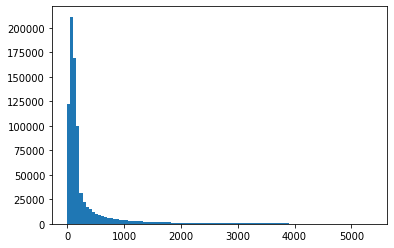

In [7]:
import matplotlib.pyplot as plt
import math
doc_lengths = articles_cleaned_rdd.map(lambda x: len(x['text']))
doc_lengths = doc_lengths.filter(lambda x: x != 0)

sd = math.sqrt(doc_lengths.variance())
mean = doc_lengths.mean()

print('sd is: ', sd)
print('mean is: ', mean)

doc_lenghts_outliers_removed = doc_lengths.filter(lambda x: mean -3*sd <x<mean + 3*sd)


hist = doc_lenghts_outliers_removed.histogram(100)


plt.hist(hist[0][:-1] , hist[0], weights=hist[1])
plt.show()

# print(hist[1])
# print(hist[0])
# print(sd)
# print(mean)


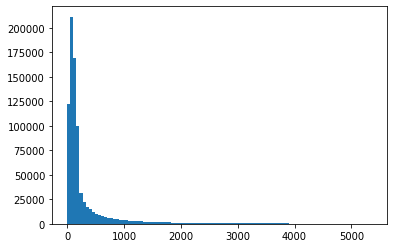

### What are the top 100 most common english words in the corpus?

<div dir="rtl">

برای پیدا کردن کلمات انگلیسی، با استفاده از یک
regex
ساده، تمامی کلماتی که با حروف انگلیسی نوشته شده‌اند را می‌یابیم. سپس آن‌ها را بر اساس تکرار مرتب می‌کنیم. 

</div>

In [ ]:
import re

pattern = re.compile(r"^[A-Za-z]+$")

top100_english = words_count_after_cleaning.filter(lambda x: not pattern.match(x[0]) is None).sortBy(lambda x: x[1], ascending=False)
top100_english.take(100)


output:
[('gt', 23402),
 ('lt', 22198),
 ('of', 14862),
 ('The', 9668),
 ('A', 9126),
 ('the', 8477),
 ('amp', 7943),
 ('http', 7544),
 ('Wikipedia', 7389),
 ('s', 7314),
 ('n', 7231),
 ('org', 6802),
 ('C', 6778),
 ('and', 6721),
 ('x', 6372),
 ('a', 6176),
 ('County', 5717),
 ('en', 5697),
 ('de', 5440),
 ('B', 5287),
 ('wikipedia', 5110),
 ('g', 4954),
 ('in', 4698),
 ('i', 4617),
 ('w', 4617),
 ('District', 4213),
 ('S', 3981),
 ('index', 3886),
 ('Free', 3822),
 ('title', 3813),
 ('I', 3806),
 ('to', 3795),
 ('php', 3790),
 ('Township', 3742),
 ('Encyclopedia', 3736),
 ('mol', 3699),
 ('www', 3652),
 ('contributors', 3616),
 ('https', 3564),
 ('X', 3526),
 ('oldid', 3481),
 ('com', 3292),
 ('accessed', 3215),
 ('D', 3153),
 ('m', 3105),
 ('T', 3061),
 ('R', 3031),
 ('II', 3017),
 ('E', 2952),
 ('P', 2891),
 ('N', 2874),
 ('c', 2819),
 ('M', 2779),
 ('III', 2752),
 ('G', 2684),
 ('p', 2681),
 ('L', 2674),
 ('b', 2650),
 ('for', 2617),
 ('k', 2608),
 ('d', 2571),
 ('Canton', 2554),
 ('V', 2473),
 ('F', 2406),
 ('y', 2382),
 ('national', 2376),
 ('team', 2338),
 ('O', 2274),
 ('women', 2231),
 ('wiki', 2214),
 ('H', 2180),
 ('DNA', 2122),
 ('t', 2104),
 ('f', 2069),
 ('under', 2048),
 ('football', 2011),
 ('K', 1913),
 ('web', 1822),
 ('e', 1749),
 ('is', 1655),
 ('on', 1645),
 ('if', 1627),
 ('j', 1619),
 ('district', 1598),
 ('ir', 1594),
 ('r', 1593),
 ('int', 1564),
 ('Y', 1533),
 ('Municipality', 1523),
 ('v', 1489),
 ('U', 1470),
 ('ref', 1429),
 ('end', 1421),
 ('br', 1392),
 ('New', 1379),
 ('J', 1367),
 ('section', 1362),
 ('model', 1260),
 ('La', 1243),
 ('ns', 1238)]

### What is the url of the longest article?

<div dir="rtl">



در این مرحله از هر مقاله یک دوتایی به صورت آدرس مقاله و طول آن درست می‌کنیم و بر اساس طول مرتب می‌کنیم. سپس اولین ردیف را به عنوان خروجی در نظر می‌گیریم.

</div>

In [13]:
urls_lengths = articles_cleaned_rdd.map(lambda x: (len(x['text']), x['url'])).sortBy(lambda x: x[0], ascending=False)
urls_lengths.take(1)

[(131241, 'https://fa.wikipedia.org/wiki?curid=6522')]

output: 
[(131241, 'https://fa.wikipedia.org/wiki?curid=6522')]

### How many articles contain your first name?!

<div dir="rtl">

تمامی مقالاتی که اسم من را دارند را فیلتر می‌کنیم و سپس تعداد آن‌ها را می‌شماریم.


</div>


In [14]:
name = 'امین'
articles_cleaned_rdd.filter(lambda x: name in x['text']).count()

11863

In [ ]:
11863

# Section 4: TF-IDF + Search (40 Points)

In [ ]:
word_df_rdd = #TODO: calculate document frequncy for each word
articles_tf_idf_vectors = #TODO: add `vector` key to articles_cleaned_rdd dictionary with the tf_idf dictionary

<div dir="rtl">

ابتدا تعداد کل مقالات را به دست می‌آوریم. برای به دست آوردن 
df
کافی است تعداد مقالاتی که هر کلمه در آن‌ها آمده است را بشماریم. برای این کار مجموعه‌ای (نه آرایه) از کلمات یک مقاله به دست می‌آوریم و به ازای هر کلمه دوتایی 
(کلمه، ۱) را می‌سازیم. 
سپس با یک 
reduce
به ازای هر کلمه تعداد تکرار آن‌ در مقالات مختلف را به دست می‌آوریم. سپس برای به دست آوردن 
idf
، 
به کمک فرمولی که در ویکیپدیا آمده است، محاسبات لازم را به دست می‌آوریم. در این مرحله از فرمول زیر استفاده کرده‌ام:

$\text{idf} = \log(\frac{N}{1+n_t})$

زیرا با خواندن ویکیپدیا به نظر من منطقی ترین بود. در واقع دلیل فرمول گفته شده در اول این مقاله را متوجه نشدم. برای به دست آوردن 
tf
نیز کافی است تعداد تکرار‌ها هرکلمه در هر مقاله را به دست آوریم. از فرمول زیر استفاده شده است:

$\text{tf} = \frac{f_{t,d}}{len(d)}$

که 
$f_{t,d}$
تعداد تکرار کلمه‌ی 
t
در مقاله‌ی 
d 
است. در آخر نیز با ضرب کردن 
tf
در
idf
مربوطه، 
td-idf
هر کلمه (در هر مقاله) را به دست می‌آوریم و در دیکشنری مربوط با کلید 
vector 
قرار می‌دهیم. 



</div>


In [4]:
import math
num_articles = articles_cleaned_rdd.count()


word_df_rdd = articles_cleaned_rdd.flatMap(lambda x: [(word, 1)  for word in set(x['text'].split() + x['title'].split()) ] ).reduceByKey(lambda a,b: a+b)
word_idf_rdd = word_df_rdd.map(lambda x: ( x[0], math.log(num_articles/(1+x[1])) ) )

word_tf_rdd = articles_cleaned_rdd.flatMap(lambda x: [((word, x['id']), 1/len(x['text']+x['title'])) for word in x['title'].split() + x['text'].split()] ).reduceByKey(lambda a,b: a+b).map(lambda x: (x[0][0], (x[0][1], x[1])))


articles_tf_idf_vectors = word_tf_rdd.join(word_idf_rdd)
articles_tf_idf_vectors = articles_tf_idf_vectors.map(lambda x: (x[1][0][0], (x[0], x[1][0][1]*x[1][1]) ) )
articles_tf_idf_vectors = articles_tf_idf_vectors.groupByKey().mapValues(dict)

articles_cleaned_rdd_with_vector = articles_cleaned_rdd.map(lambda x: (x['id'], x)).join(articles_tf_idf_vectors).map(lambda x: {**x[1][0], 'vector':x[1][1]})
articles_cleaned_rdd_with_vector.take(1)



[{'id': '37809',
  'revid': '616716',
  'text': 'نورالله تالقانی تاریخ نگاران نویسندگان روزنامه نگاران برجسته ترین چهره سیاسی معاصر افغانستان زندگی نورالله تالقانی سال ۱۳۱۸ خورشیدی برابر ۱۹۳۹ میلادی قریۀ سرای سنگ شهر تالقان مرکز ولایت تخار شمال افغانستان زاده نورالله تالقانی بمثابۀ پژوهشگر تاریخ نگار نویسنده ناشر فهرست طویلی کتاب علمی تاریخی سیاسی اجتماعی ادبی خدمات بزرگ فراموش ناشدنی مردم افغانستان بویژه اهل فرهنگ انجام زندگی نورالله تالقانی مشحون مبارزه راه برابری ملی اجتماعی فعالیت گستردۀ روشنگرانه دگروال نورالله تالقانی تبار دلیر مردان نامی چهره معدود فرهنگی تاریخ معاصر کشور افغانستان حلقه روشنفکران میهنی چه ساحه نظامی چه ملکی دارای جایگاه خاصی ویژگی خاص شادروان تالقانی بی خوف بی هراس دردهای مردم ستمدیدۀ خویش صراحت بازگو بیان نمود دلیرانه دفاع نماد راستین تلاش راه فراگیری علم دانش نماد راستین پیکار بی امان راه حق طلبی برابری زیستن تمام عمر زندگی پربار پرافتخار خویش صرف مطالعه نوشتن کتاب مطالب ناب پژوهشی علمی نمود تالقانی وسعت نظر نیک دور اندیشی کامل تحلیل درست توان شهامت خاصی برخور

## Searching

<div dir="rtl">

برای مقایسه کوئری داده‌شده، فرض می‌کنیم آن نیز یک مقاله است. حال کافی است روشی برای مقایسه دو مقاله پیدا کنیم. برای این کار، اگر برای هر مقاله یک بردار خیلی بزرگ از
tf-idf
تمام کلمات بسازیم، می‌توانیم مقالات را با هم مقایسه کنیم. هرچه این بردارها به هم شبیه تر باشند، دو مقاله بهم شبیه‌‌تر هستند. برای پیدا کردن شباهت این بردار‌ها نیز به سادگی از فاصله‌ی کسینوسی استفاده می‌کنیم. 

نکته‌ی مهمی که در این محاسبات وجود دارد این است که کلماتی که در هر دو مقاله وجود ندارند، تاثیری در محاسبه‌ی فاصله‌ی کسینوسی ندارد. و این یعنی تنها کافی است  از اجتماع کلمات برای به دست آوردن بردار
tf-idf 
استفاده کنید.  زیرا ضرب دو درایه متناظر صفر می‌شود و در محاسبه‌ی اندازه‌ی دو بردار نیز تاثیر ندارند. 

</div>

In [5]:
from scipy.spatial.distance import cosine

query = 'هخامنشیان ساسانیان هگمتانه'

q_tf_idf = {
    'هخامنشیان': word_idf_rdd.lookup('هخامنشیان')[0] if word_idf_rdd.lookup('هخامنشیان') else math.log(num_articles),
    'ساسانیان': word_idf_rdd.lookup('ساسانیان')[0] if word_idf_rdd.lookup('ساسانیان') else math.log(num_articles),
    'هگمتانه': word_idf_rdd.lookup('هگمتانه')[0] if word_idf_rdd.lookup('هگمتانه') else math.log(num_articles)
}


def similarity(x):
  x_tf_idf = x['vector']

  # print('q is: ', q)
  # print('v is: ', v)

  keys = q_tf_idf.keys() | x_tf_idf.keys()
  # print('keys are: ', keys)
  sort = sorted(keys)
  # print('keys after sort: ', sort)

  x_tf_idf_vector = [None]*len(sort)
  q_tf_idf_vector = [None]*len(sort)
  for i, key in enumerate(sort):
    x_tf_idf_vector[i] = x_tf_idf.get(key, 0)
    q_tf_idf_vector[i] = q_tf_idf.get(key, 0)

  # print(v_vector)
  # print(q_vector)

  distance = cosine(x_tf_idf_vector, q_tf_idf_vector)

  # print(distance)

  return (x['url'], distance)

# similarity(x)


# top_10_similar = #TODO: find similar wikipedia articles based on cosine similarity of tf-idf vectors

top_10_similar = articles_cleaned_rdd_with_vector.map(similarity).sortBy(lambda x: x[1], ascending=True)
top_10_similar.take(10)
# top_10_similar = top_10_similar




[('https://fa.wikipedia.org/wiki?curid=2623108', 0.3588232414820446),
 ('https://fa.wikipedia.org/wiki?curid=1152238', 0.3588232414820446),
 ('https://fa.wikipedia.org/wiki?curid=1165361', 0.39370446029345785),
 ('https://fa.wikipedia.org/wiki?curid=1234129', 0.40427629160174783),
 ('https://fa.wikipedia.org/wiki?curid=3554441', 0.44839310683020084),
 ('https://fa.wikipedia.org/wiki?curid=16668', 0.4823003303107112),
 ('https://fa.wikipedia.org/wiki?curid=1421451', 0.5058231099374553),
 ('https://fa.wikipedia.org/wiki?curid=77900', 0.5058231099374553),
 ('https://fa.wikipedia.org/wiki?curid=4765912', 0.5184505791783438),
 ('https://fa.wikipedia.org/wiki?curid=3540559', 0.5339559874831294)]

[('https://fa.wikipedia.org/wiki?curid=2623108', 0.3588232414820446),

 ('https://fa.wikipedia.org/wiki?curid=1152238', 0.3588232414820446),

 ('https://fa.wikipedia.org/wiki?curid=1165361', 0.39370446029345785),

 ('https://fa.wikipedia.org/wiki?curid=1234129', 0.40427629160174783),
 
 ('https://fa.wikipedia.org/wiki?curid=3554441', 0.44839310683020084),
 
 ('https://fa.wikipedia.org/wiki?curid=16668', 0.4823003303107112),
 
 ('https://fa.wikipedia.org/wiki?curid=1421451', 0.5058231099374553),
 
 ('https://fa.wikipedia.org/wiki?curid=77900', 0.5058231099374553),
 
 ('https://fa.wikipedia.org/wiki?curid=4765912', 0.5184505791783438),
 
 ('https://fa.wikipedia.org/wiki?curid=3540559', 0.5339559874831294)]